# Data Augmentation for Deep Learning


In this notebook, we describe various techniques to perform data augmentation used in training a TensorFlow-Keras based Deep Learning model. Data augmentation may or may not be a part of data preprocessing pipeline. For example, when training is done by a single device (CPU or GPU), data augmentation is typically done during preprocessing. However, in distributed training (using multiple GPUs), we can expedite the training time by integrating data augmentation into the learning model so that it is done by GPUs.

Thus, as we present various techniques for data augmentation, we keep in mind the following two broad implementation scenarios. 
- Data Augmentation during Data Preprocessing
- Data Augmentation during Training



## Data Augmentation: Various Techniques

The standard choice of a data augmentation technique is **Keras ImageDataGenerator** class. In general, Keras image data preprocessing API is very convenient to build a data preprocessing pipeline and is a go-to option for **small projects**. 

https://keras.io/api/preprocessing/image/#image-data-preprocessing

In this notebook, we briefly introduce the ImageDataGenerator class. Next notebook provides a description of various augmentation methods of this class.

- The main limitation of the ImageDataGenerator class is that it is **not efficient**. It adds significant delay in data preprocessing. Thus, it is not suitable for large projects.

An efficient alternative to build the data pipeline for large projects is to use the **tf.data** API. In this approach, we represent the dataset as a tf Dataset object, then apply various transformations including data augmentation. For performance benefit, data augmentation should be done using TensorFlow operations or ops. An op is a node in the TensorFlow graph, which is used to represent computations in the TensorFlow ecosystem. Various augmentation ops are defined in the **tf.image** module.
https://www.tensorflow.org/api_docs/python/tf/image

- Although the tf.image module is very efficient, it is **not always flexible**. For example, its rotation function is limited to a fixed 90 degree and is applied deterministically.

For flexibility, a great choice is **Keras image preproessing layer** API. It uses the Sequential API to build data augmentation pipeline. The best part of it is that we can conveniently incorporate this data augmentation layer inside a model and perform augmentation during training, which is a suitable approach in distributed training (for **large projects**).

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

In this notebook, we emphasize two aspects of the data augmentation pipeline.
- Efficiency (required in large projects)
- Flexibility (required in large projects and complex problems)

Based on these two considerations, we recommed:
- Small projects: Keras ImageGenerator 
- Large projects (distributed training): Keras image preprocessing layer (it can be combined with TensorFlow image ops as well as arbitrary python functions)

We present the following data augmentation techniques.
- Keras ImageGenerator
- TensorFlow Image Ops (tf.image module)
- TensorFlow Addons Image Ops (tfa.image module)
- Keras Image Preprocessing Layer
- Flexible Data Augmentation Layer
    - Using Python Library Functions as TensorFlow Ops 
    - Combining TensorFlow Image Ops with Keras Preprocessing Layer

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndimage

import tensorflow as tf
import tensorflow_addons as tfa

## Load an Image for Augmentation

For illustration, we use a single JPEG-encoded image.

We load the image from the disk and convert it into a float32 tensor. We also scale the image.

Image Datatype:  <dtype: 'float32'>
Image Shape:  (427, 640, 3)

Tensor max value:  1.0
Tensor max value:  0.0


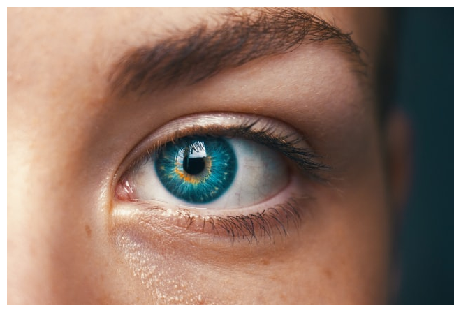

In [2]:
# Get the path to the roor directory
ROOT_DIR = os.path.abspath(os.curdir)

# Create the path to the image file
image_path = os.path.join(ROOT_DIR, 'datasets/pics/Eye.jpg')

# Returns a tensor with the entire contents of the input filename without doing any parsing
image = tf.io.read_file(image_path)

# Decode a JPEG-encoded image to a uint8 tensor
image = tf.image.decode_jpeg(image, channels=3)
    
# Convert the unit8 tensor to floats in the [0,1] range
# Images that are represented using floating point values are expected to have values in the range [0,1]
image = tf.image.convert_image_dtype(image, tf.float32)

print("Image Datatype: ", image.dtype)
print("Image Shape: ", image.shape)

print("\nTensor max value: ", tf.reduce_max(image).numpy())
print("Tensor max value: ", tf.reduce_min(image).numpy())

# Display the image tensor
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

## Create a Batch

In a Deep Learning project, data augmentation is applied on batches of images. The data augmentation functions require us to pass a 4D tensor as input. The first dimension should be the number of samples (batch size), followed by height, width, and channels. 

In this demo, since we are using a single RGB image, we need to add an extra axis at the beginning of the 3D image to convert it into a 4D tensor.

We do this by expanding dimension to one sample by using the tf.expand_dims function. This function expands the array by inserting a new axis at the specified position. Two parameters are required by this function: Input array, position where new axis to be inserted

In [3]:
# Add the image to a batch
image_batch = tf.expand_dims(image, axis=0)
print("Shape of the batch: ", image_batch.shape)

Shape of the batch:  (1, 427, 640, 3)


## Keras ImageGenerator Class

For small projects, we may use Kears **ImageDataGenerator** class to perform various augmentations including standardization, rotation, shifts, flips, brightness change.
https://keras.io/api/preprocessing/image/#imagedatagenerator-class


## How the ImageDataGenerator Class Works

An **ImageDataGenerator** object provides real-time data augmentation, i.e., it generates augmented images **on the fly** while the model is still in the training stage. Essentially it intercepts the original data, randomly transforms it, then returns the augmented data for training. It works in following 3 stages.

- An input batch of images is fed to the ImageDataGenerator object.
- It transforms each image in the batch by a series of random translations, rotations, etc.
- The randomly transformed batch is then returned to the calling function.

Note that, it only returns the augmented images without adding those to the original training/validation dataset. It loads the images in batches, which saves a lot of memory.


        -- See the next notebook for an in-depth presentation of various ImageGenerator methods.

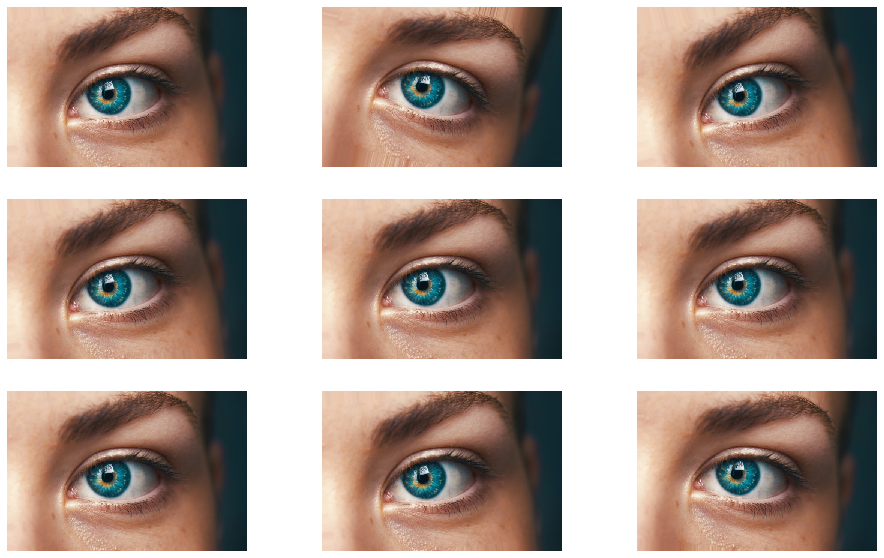

In [4]:
'''
For illustration purpose, we only only show the rotation-based augmentation.
'''

rotation_degree = 20

'''
Create an image data augmentation generator object for performing random rotation
'''
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=rotation_degree)


'''
Create an iterator object that takes data and label arrays, batch size.
It returns an iterator yielding tuples of (x, y) 
where x is a numpy array of image data (in the case of a single image input) 
or a list of numpy arrays (in the case with additional inputs) and 
y is a numpy array of corresponding labels. 
'''
it = datagen.flow(x=image_batch, y=None, batch_size=1)

# Generate samples and plot
plt.figure(figsize=(16,10))

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # plot raw pixel data
    plt.imshow(batch[0])
    plt.axis("off")
plt.show()

## TensorFlow Image Ops (tf.image module)

Below we show how to use the tf.image.rot90() function. This function performs 90 degree rotation deterministically. We write a small function to apply the rotation stochastically.

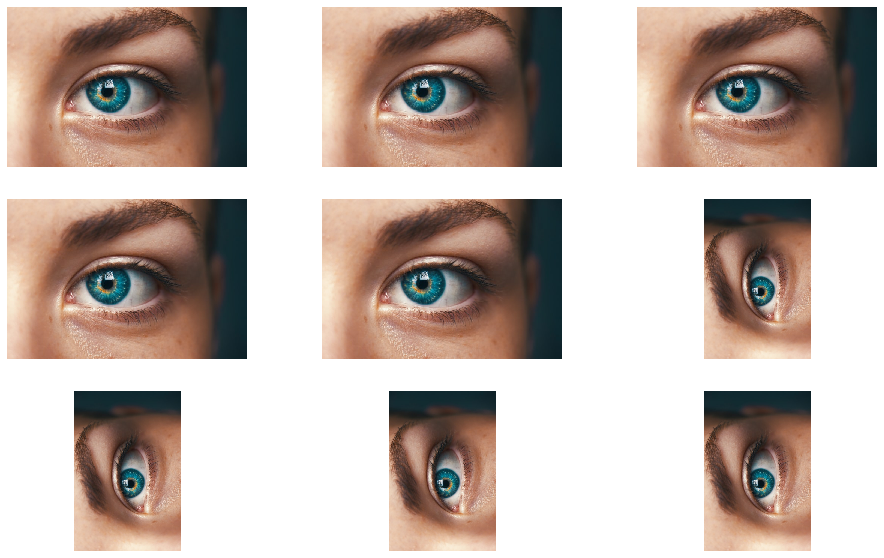

In [5]:
def random_rotation_tf_image(x):
    # Select a random value from a uniform distribution between 0 ~ 1
    rand_value = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)

    # Perform a random 90 degree rotation on the input 
    return tf.cond(rand_value < 0.5, lambda: x, lambda: tf.image.rot90(x))


plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = random_rotation_tf_image(image_batch)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0]) # select the image from the batch
    plt.axis("off")

## TensorFlow Addons Image Ops (tfa.image module)

This module provides additional image manipulation ops.

TensorFlow Addons is a repository of contributions that conform to well-established API patterns, but implement new functionality not available in core TensorFlow. 

We show how to apply the tfa.image.rotate() function stochastically.

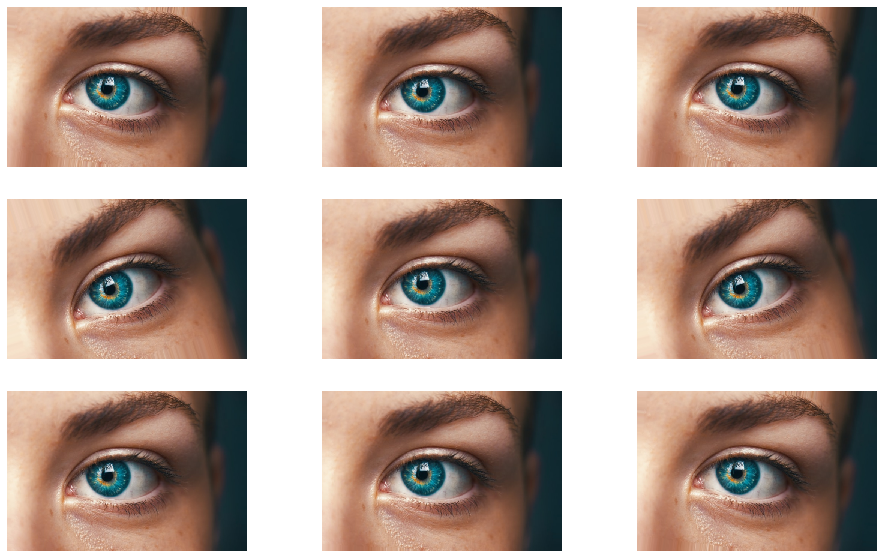

In [6]:
# Randomly rotate an image within the range of a given degree
def random_rotation_tfa(x, rotation_angle_degree):
    rotation_angle_radian = rotation_angle_degree * (3.1416/ 180)
    
    x = tfa.image.rotate(x, np.random.uniform(-rotation_angle_radian, rotation_angle_radian),
                             fill_mode='nearest', interpolation='bilinear')
    return x


rotation_degree = 20

plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = random_rotation_tfa(image_batch, rotation_degree)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## Keras Image Preprocessing Layer


This API allows to build a standalone preprocessing and augmentation layer, which can be integrated in a Keras model.


For image preprocessing and augmentation, following layers are available.

#### Image preprocessing layers

These layers are for standardizing the inputs of an image model.

- Resizing layer: resizes a batch of images to a target size.
- Rescaling layer: rescales and offsets the values of a batch of image (e.g. go from inputs in the [0, 255] range to inputs in the [0, 1] range.
- CenterCrop layer: returns a center crop of a batch of images.

#### Image data augmentation layers
These layers apply random augmentation transforms to a batch of images. They are only active during training.

- RandomCrop layer
- RandomFlip layer
- RandomTranslation layer
- RandomRotation layer
- RandomZoom layer
- RandomHeight layer
- RandomWidth layer


The good thing about the Keras data augmentation layers is that these augmentations are applied stochastically.

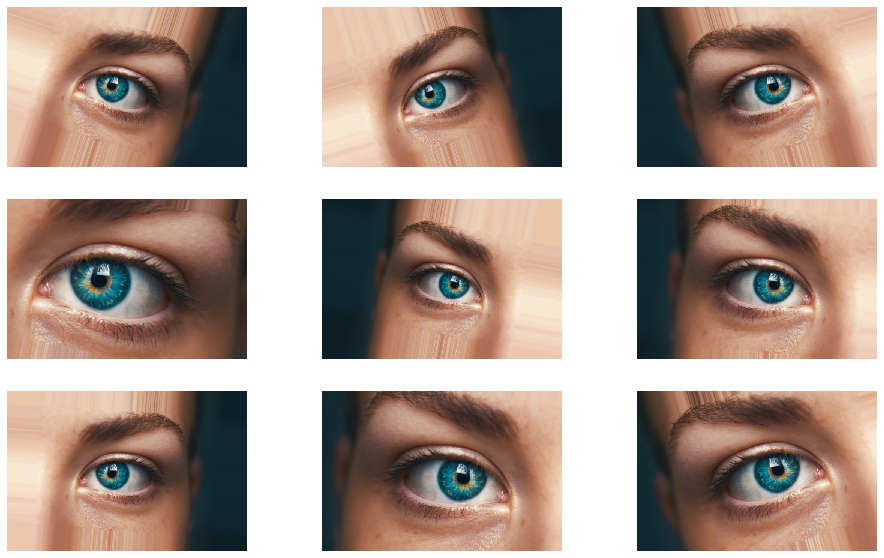

In [7]:
'''
Following augmentations are performed.
- Random zoom
- Random rotation
- Random horizontal flip


______________________________________________________________________________________________
  
Random Zoom:

We set the following parameters.

- height_factor:
a float represented as fraction of value, or a tuple of size 2 representing lower and upper bound 
for zooming vertically. 
When represented as a single float, this value is used for both the upper and lower bound. 
A positive value means zooming out, while a negative value means zooming in. 

- width_factor:
We keep the defaut "None" value.
It ensures zooming vertical and horizontal directions by preserving the aspect ratio.

- fill_mode='nearest'
The input is extended by the nearest pixel.

- interpolation='bilinear'

______________________________________________________________________________________________


Random Rotation:

We set the following parameters.

- factor
a float represented as fraction of 2pi, or a tuple of size 2 representing lower and upper bound 
for rotating clockwise and counter-clockwise. 
A positive values means rotating counter clock-wise, while a negative value means clock-wise. 
When represented as a single float, this value is used for both the upper and lower bound. 

NOTE that the "factor" argument determines the rotation angle in **radian**.
For convenience, we pass the rotation angle in degree, and divide it by 360 (2pi) to convert it into radian.

- fill_mode='nearest'
The input is extended by the nearest pixel.

- interpolation='bilinear'

______________________________________________________________________________________________


Random Flip:

We set the following parameter.

- mode
String indicating which flip mode to use. Can be "horizontal", "vertical", or "horizontal_and_vertical". 
'''

zoom_height_factor = 0.5
rotation_degree = 20


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(zoom_height_factor, width_factor=None, 
                                                          fill_mode='nearest', interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(rotation_degree/360, 
                                                              fill_mode='nearest', interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
])


plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = data_augmentation(image_batch)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## A Convenient Function for Keras Data Preprocessing Layer

It is useful to have a data augmentation layer function that we can customize by providing suitable values for individual augmentation parameters.

Below we define such an augmentation function for the Keras preprocessing layer that can be used either during data preprocessing or in a model.

This function allows to pass values to set various augmentation parameters in the used layers.

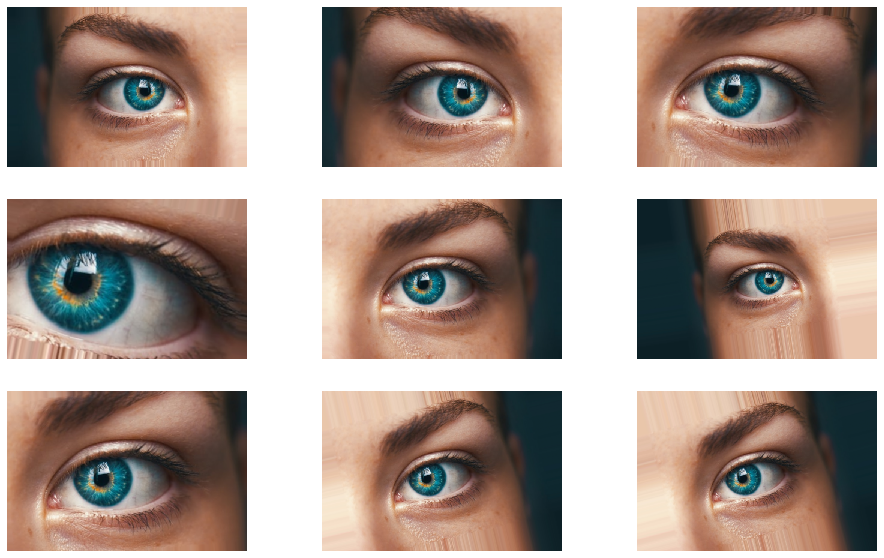

In [8]:
'''
Define the DataAugmentation class using the tf.Keras' Sequential API.
It creates a data augmentation layer for performing following augmentation to input data:
- Random zoom
- Random rotation
- Random horizontal flip
'''

class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, rotation_angle_degree, zoom_height_factor, **kwargs):
        super().__init__(**kwargs)
        self.augmentation_layers = [] 
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomZoom(zoom_height_factor, width_factor=None, 
                                                                                              fill_mode='nearest', interpolation='bilinear'))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomRotation(rotation_angle_degree/360, 
                                                                                                  fill_mode='nearest', interpolation='bilinear'))
        self.augmentation_layers.append(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
        
      
    def call(self, inputs):
        Z = inputs
        for layer in self.augmentation_layers:
            Z = layer(Z)
        return Z
  

# This function creates a sequential tf.Keras layer for performing data augmentation
def data_augmentation_layer(rotation_angle_degree, zoom_height_factor):
    
    d_augmentation = tf.keras.models.Sequential(name='Data-Augmentation')
    d_augmentation.add(DataAugmentation(rotation_angle_degree, zoom_height_factor))

    return d_augmentation  


# Create a data augmentation layer objet by providing augmentation arguments
data_augmentation = data_augmentation_layer(rotation_angle_degree=20, zoom_height_factor=0.6)

plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = data_augmentation(image_batch)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

## Flexible Data Augmentation Layer


We now discuss how to create a flexible augmentation layer. Specifically we provide two techniques.

    - Using Python Library Functions as TensorFlow Ops
    - Combining TensorFlow's Image Ops with Keras' Preprocessing Layer




## Using Python Library Functions as TensorFlow Ops

Sometimes we may want to use arbitrary python functions for data preprocessing and integrate those into the Keras preprocessing layer.

The problem is that a python function is executed in eager mode. To use it as a TensorFlow operation (i.e., in graph mode), we need to wrap it as a tf operation. This can be done by using the tf.py_function.

This wrapping is required when the input (e.g., image) is loaded as a tf Dataset object. The rotation (or any transformation) on the Dataset object is performed using its map() method. The map() argument function (i.e., the rotation function written using python) must be executed as a graph.

To use Python code inside of the function we have a few options:
- Use AutoGraph to convert Python code into an equivalent graph computation. 
- Use tf.py_function, which allows us to write arbitrary Python code.

We use the latter option. For more information:
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map


The tf_py_function requires us to describe:
- the input (via the "inp" argument)
- the return shapes and types (via the "Tout" argument)
    

First, we define a python rotation function. We use the scipy.ndimage library.

Then, we apply this SciPy augmentation function on a Dataset object by converting it into a TensorFlow op.


## SciPy Image Processing Library 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


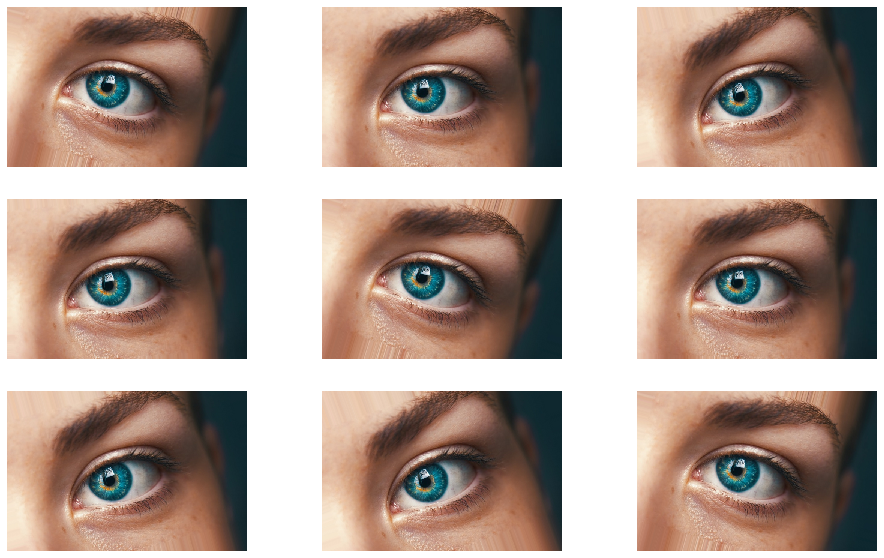

In [9]:
# Randomly rotate an image within the range of a given degree by using the SciPy function
def random_rotate_image_scipy(image, rotation_angle):
    image = ndimage.rotate(image, np.random.uniform(-rotation_angle, rotation_angle), 
                           reshape=False, mode='nearest')
    return image

rotation_degree = 20

plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = random_rotate_image_scipy(image_batch[0], rotation_degree)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

## Apply a SciPy Augmentation Function on a Dataset Object

In [10]:
# Load the image as a tf Dataset object
image_dataset = tf.data.Dataset.from_tensors(image)
print(image_dataset)

# Create a dummy label
label = tf.data.Dataset.from_tensors([1.0])
print(label)

# Create image-label Dataset object
image_ds = tf.data.Dataset.zip((image_dataset, label))
print(image_ds)

<TensorDataset shapes: (427, 640, 3), types: tf.float32>
<TensorDataset shapes: (1,), types: tf.float32>
<ZipDataset shapes: ((427, 640, 3), (1,)), types: (tf.float32, tf.float32)>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


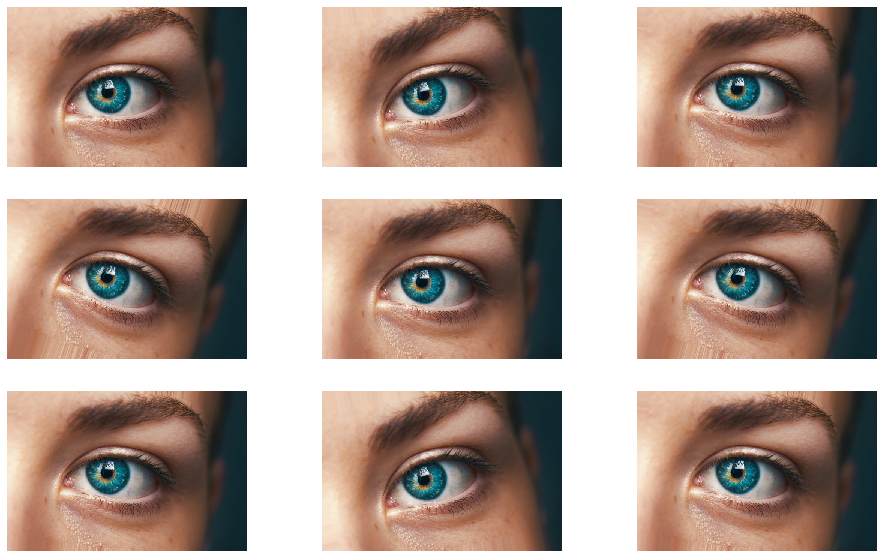

In [11]:
# A wrapper function to convert a python function into a tf graph
# Using the "inp" argument we provide the rotation degree in angle
def random_rotate_image_tf_py(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image_scipy, inp=[image, 20], Tout=[tf.float32])
    image.set_shape(im_shape)
    return image, label


# Apply the rotation transformation on the Dataset object
image_ds = image_ds.map(random_rotate_image_tf_py)

# A utility function to emit the image from the Dataset
def get_image_from_ds(ds):
    for image, label in ds.take(1):
        image
    return image


# Display randomly rotated images
plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = get_image_from_ds(image_ds)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

## Combining TensorFlow Image Ops with Keras Preprocessing Layer


Below we show how to combine TensorFlow ops with the Keras preprocessing Sequential layer.

First, we define a **TensorFlowOpAugmentation** class that applies two TensorFlow ops for image transformation.

Then, we create a Keras preprocessing layer by adding a TensorFlowOpAugmentation object.

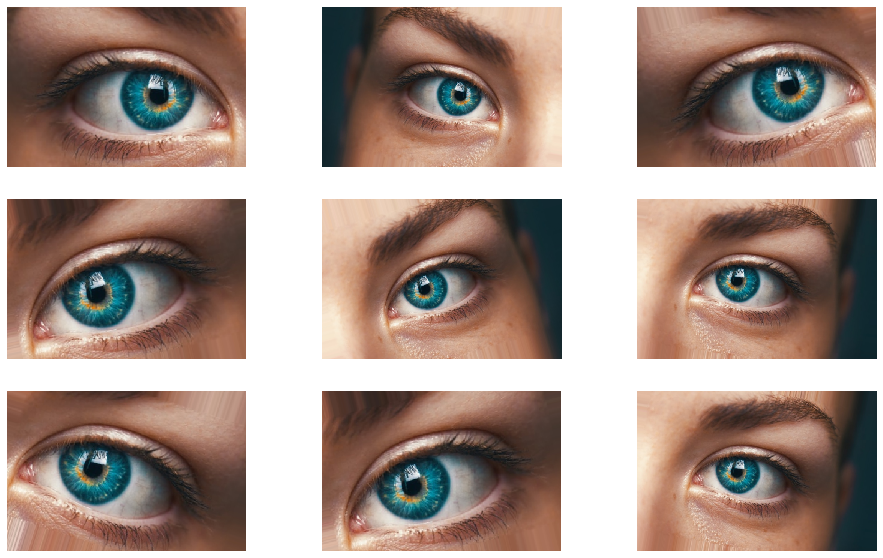

In [12]:
class TensorFlowOpAugmentation(object):
    
    def __init__(self, flip_proba, crop_proba, crop_fraction, **kwargs):
        super().__init__(**kwargs)
        self.flip_proba = flip_proba
        self.crop_proba = crop_proba
        self.crop_fraction = crop_fraction
    
    
    def __call__(self, image):        
        # Apply horizontal flip randomly
        img = self._random_apply(tf.image.flip_left_right, image, proba=self.flip_proba)
        # Apply central crop randomly
        img = self._random_apply(tf.image.central_crop, img, proba=self.crop_proba, 
                                 central_fraction=self.crop_fraction)
        return img
    
    
    # It applies the "func" randomly on an image
    def _random_apply(self, func, x, proba, **kwargs):
        # Select a random value from a uniform distribution between 0 ~ 1
        rand_value = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)
        
        # Cast the probability as a float32 tensor
        proba = tf.cast(proba, tf.float32)
        
        # Return randomly transformed image
        return tf.cond(rand_value < proba, lambda: x, lambda: func(x, **kwargs))
    
    

rotation_angle_degree = 20
    
# Build the Keras preprocessing layer by adding the TensorFlowOpAugmentation class
data_augmentation_custom = tf.keras.Sequential([
    tf.keras.layers.Lambda(TensorFlowOpAugmentation(flip_proba=0.8, crop_proba=0.5, crop_fraction=0.6)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(rotation_angle_degree/360,
                                                             fill_mode='nearest', interpolation='bilinear')
])


plt.figure(figsize=(16, 10))
for i in range(9):
    augmented_image = data_augmentation_custom(image_batch)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")